In [1]:
import scipy.special as sp
import math as ma
import numpy as np 
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import scipy as sc
import bayes_splicing as bs
from joblib import Parallel, delayed

# Inverse Gaussian distribution

$X\sim\text{IG}(\mu, \lambda)$ with pdfs

$$
f(x) = \sqrt{\frac{\lambda}{x^3 2\pi}}\exp\left[- \lambda \frac{(x-\mu)^2}{2x\mu^2}\right]
$$

In [28]:
def phi_vec(z):
    """
    Cdf of unit normal distribution

    Parameters
    ----------
    z : Float

    Returns
    -------
    CDF of unit normal distribution
    """
    return( 1 / 2 * (1 + sp.erf(z /np.sqrt(2))))

@nb.jit(nopython=True)
def phi_jit(z):
    """
    Cdf of unit normal distribution

    Parameters
    ----------
    z : Float

    Returns
    -------
    CDF of unit normal distribution
    """
    return( 1 / 2 * (1 + ma.erf(z /np.sqrt(2))))

class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logp(self, X):
        if self.name == "Inverse-Gaussian":
            def logp(parms):
                μ, λ = parms
                if np.all(parms) > 0:
                    return(len(X) / 2 * (np.log(λ) - np.log(2 * ma.pi) ) - 
                           3 / 2 * np.sum(np.log(X)) - 
                           λ / 2 / μ**2 * np.sum((X - μ)**2 / X))
                else:
                    return(-np.inf)
        self.logp = nb.jit(nopython = True)(logp)
    
    def set_logps(self):
        if self.name == "Inverse-Gaussian":
            def logp_body(X, parms,  γ):
                μ, λ = parms
                F1 = phi_jit(np.sqrt(λ / γ) * (γ/μ - 1)) + np.exp(2 * λ / μ) * phi_jit(- np.sqrt(λ / γ) * (γ/μ + 1)) 
                if np.all(parms) > 0 and F1 > 0:
                    return(len(X) / 2 * (np.log(λ) - np.log(2 * ma.pi) ) - 
                           3 / 2 * np.sum(np.log(X)) - 
                           λ / 2 / μ**2 * np.sum((X - μ)**2 / X) - len(X) * np.log(F1))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                μ, λ = parms
                F2 = phi_jit(np.sqrt(λ / γ) * (γ/μ - 1)) + np.exp(2 * λ / μ) * phi_jit(- np.sqrt(λ / γ) * (γ/μ + 1)) 
                if np.all(parms) > 0 and F2 < 1:
                    return(len(X) / 2 * (np.log(λ) - np.log(2 * ma.pi) ) - 
                           3 / 2 * np.sum(np.log(X)) - 
                           λ / 2 / μ**2 * np.sum((X - μ)**2 / X) - len(X) * np.log(1 - F2))
                else:
                    return(-np.inf)
            
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logd(self, parms):
        if self.name == "Inverse-Gaussian":
            def logd(x):
                μ, λ = parms[:,0], parms[:,1]
                res = np.zeros(len(μ))
                s = np.logical_and(μ > 0, λ > 0)
                res[np.where(s)] =  (np.log(λ[s]) - np.log(2 * ma.pi)) / 2  - 3 / 2 * np.log(x) - λ[s] / 2 / μ[s]**2 * (x - μ[s])**2 / x
                res[np.where(np.invert(s))] = -np.inf
                return(res)
        self.logd = logd
    
    def set_logds(self):
        if self.name == "Inverse-Gaussian":
            
            def logd_body(x, parms,  γ):
                μ, λ = parms[:,0], parms[:,1]
                F1 = phi_vec(np.sqrt(λ / γ) * (γ/μ - 1)) + np.exp(2 * λ / μ) * phi_vec(- np.sqrt(λ / γ) * (γ/μ + 1)) 
                res = np.zeros(len(μ))
                s = np.logical_and(np.logical_and(np.logical_and(μ > 0, λ > 0) , x < γ), F1 > 0 )
                res[np.where(s)] = (np.log(λ[s]) - np.log(2 * ma.pi)) / 2  - 3 / 2 * np.log(x) - λ[s] / 2 / μ[s]**2 * (x - μ[s])**2 / x - np.log(F1[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                μ, λ = parms[:,0], parms[:,1]
                F2 = phi_vec(np.sqrt(λ / γ) * (γ/μ - 1)) + np.exp(2 * λ / μ) * phi_vec(- np.sqrt(λ / γ) * (γ/μ + 1)) 
                res = np.zeros(len(μ))
                s = np.logical_and(np.logical_and(np.logical_and(μ > 0, λ > 0) , x > γ), F2 < 1 )
                res[np.where(s)] = (np.log(λ[s]) - np.log(2 * ma.pi)) / 2  - 3 / 2 * np.log(x) - λ[s] / 2 / μ[s]**2 * (x - μ[s])**2 / x - np.log(1 - F2[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            self.logd_body = logd_body
            self.logd_tail = logd_tail
                
    
    def set_cdf(self):
        if self.name == "Inverse-Gaussian":
            def cdf(parms, x):
                μ, λ = parms
                return( phi_jit(np.sqrt(λ / x) * (x / μ - 1)) + 
                   np.exp(2 * λ / μ) * 
                   phi_jit(- np.sqrt(λ / x) * (x / μ + 1) ))
        self.cdf = nb.jit(nopython = True)(cdf)
    
    def set_pdf(self):
        if self.name == "Inverse-Gaussian":
            def pdf(parms, x):
                μ, λ = parms
                return(np.sqrt(λ / 2 / ma.pi / x**3) * np.exp(- λ *(x - μ)**2 /2 / μ**2 / x ))
        self.pdf = nb.jit(nopython = True)(pdf)
        
    # def set_ppf(self):
    #     if self.name == "Inverse-Gaussian":
    #         self.set_cdf()
    #         def ppf(parms, y):
    #             low, up = 0, 1e8
    #             err = 1e-10
    #             while up - low > err:
    #                 new = (up + low) / 2
    #                 val = self.cdf(parms, new)
    #                 if val > y:
    #                     up = new
    #                 else: 
    #                     low = new
    #             return(new)
    #     self.ppf = ppf
    def set_ppf(self):
        if self.name == "Inverse-Gaussian":
            def ppf(parms, y):
                μ,  λ = parms
                return(st.invgauss(μ / λ).ppf(y) * λ)
        self.ppf = ppf
        
    def sample(self, parms, n):
        if self.name == "Inverse-Gaussian":
            μ, λ = parms
            res = np.zeros(n)
            y, u = (np.random.normal(size = n))**2, np.random.uniform(size = n)
            x = μ + μ**2 * y / 2 / λ - μ / 2 / λ * np.sqrt(4 * μ * λ * y + μ**2 * y**2)
            s = u < μ / (μ + x)
            res[s] = x[s]
            res[np.invert(s)] = μ**2 / x[np.invert(s)]
            return(res)

## Basic checks

In [29]:
invgauss_dist = loss_model("Inverse-Gaussian", ["μ", "λ"])
print(invgauss_dist.name, invgauss_dist.parm_names, invgauss_dist.d)
μ, λ = np.array([1/4, 1/2])
parms = np.array([μ, λ])
x, y = 2, 0.5
invgauss_dist.set_cdf(), invgauss_dist.set_pdf(), invgauss_dist.set_ppf()
invgauss_dist.cdf(parms, x) - st.invgauss(μ/λ).cdf(x/λ), invgauss_dist.ppf(parms, y) - st.invgauss(μ / λ).ppf(y) * λ, invgauss_dist.pdf(parms, x) - st.invgauss(μ/λ).pdf(x/λ) / λ

Inverse-Gaussian ['μ', 'λ'] 2


(5.551115123125783e-16, 0.0, 0.0)

## Log likelihood checks
### Part 1

In [30]:
μ, λ = np.array([2, 1])
parms = np.array([μ, λ])
X, γ = st.invgauss(μ).rvs(100), 2
invgauss_dist.set_logps(), invgauss_dist.set_logp(X)
print(invgauss_dist.logp(parms) - np.sum(np.log(st.invgauss(μ).pdf(X))))
print(invgauss_dist.logp_body(X, parms, γ)- np.sum(np.log(st.invgauss(μ).pdf(X)/ st.invgauss(μ).cdf(γ))))
print(invgauss_dist.logp_tail(X, parms, γ)-  np.sum(np.log(st.invgauss(μ).pdf(X) / (1- st.invgauss(μ).cdf(γ)) )))

5.684341886080802e-14
5.684341886080802e-14
-2.1316282072803006e-14


### Part 2

In [31]:
X = st.invgauss(μ).rvs(10)

μ_prior, λ_prior, γ_prior= bs.prior_model('gamma','μ', 1, 1), bs.prior_model('gamma','σ', 1, 1), bs.prior_model('gamma','γ', 1, 1)
prior_single_model = bs.independent_priors([μ_prior, λ_prior, γ_prior])
particle_cloud = prior_single_model.sample(20)
invgauss_dist.set_logds(), invgauss_dist.set_logd(particle_cloud.values)
μ_vec, λ_vec, γ_vec = particle_cloud.values[:,0], particle_cloud.values[:,1], particle_cloud.values[:,2]

print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) * 
                       np.exp( - λ_vec[i] / 2 / μ_vec[i]**2 / X[0] * (X[0]-μ_vec[i])**2)) for i in range(len(μ_vec))]) - invgauss_dist.logd(X[0]))
print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) * 
                       np.exp( - λ_vec[i] / 2 / μ_vec[i]**2 / X[0] * (X[0]-μ_vec[i])**2) / (phi_vec(np.sqrt(λ_vec[i] / γ_vec[i]) * (γ_vec[i] / μ_vec[i] - 1)) + 
                   np.exp(2 * λ_vec[i] / μ_vec[i]) * 
                   phi_vec(- np.sqrt(λ_vec[i] / γ_vec[i]) * (γ_vec[i] / μ_vec[i] + 1) )) ) for i in range(len(μ_vec))]) - invgauss_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]))
print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) * 
                       np.exp( - λ_vec[i] / 2 / μ_vec[i]**2 / X[0] * (X[0]-μ_vec[i])**2) / (1-(phi_vec(np.sqrt(λ_vec[i] / γ_vec[i]) * (γ_vec[i] / μ_vec[i] - 1)) + 
                   np.exp(2 * λ_vec[i] / μ_vec[i]) * 
                   phi_vec(- np.sqrt(λ_vec[i] / γ_vec[i]) * (γ_vec[i] / μ_vec[i] + 1) ))) ) for i in range(len(μ_vec))]) - invgauss_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]))


[ 4.44089210e-16  0.00000000e+00  0.00000000e+00 -1.11022302e-16
 -8.88178420e-16  0.00000000e+00  0.00000000e+00 -2.22044605e-16
 -1.11022302e-16  0.00000000e+00 -3.55271368e-15  0.00000000e+00
  0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -4.44089210e-16            -inf  0.00000000e+00]
[            inf             inf             inf             inf
             inf  0.00000000e+00             inf -1.66533454e-16
             inf             inf -3.55271368e-15 -2.22044605e-16
             inf             inf  1.11022302e-16 -1.11022302e-16
  1.11022302e-16             inf             nan             inf]
[ 0.00000000e+00  1.11022302e-16 -1.11022302e-16 -1.56125113e-16
 -8.88178420e-16             inf  1.11022302e-16             inf
 -5.55111512e-17  1.11022302e-16             inf             inf
  5.55111512e-17 -1.17961196e-16             inf             inf
             inf -3.33066907e-16             nan  0.00000000e+00]


C:\Users\pierr\AppData\Local\Temp/ipykernel_19100/2746805810.py:9: RuntimeWarning: divide by zero encountered in log
  print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) *
C:\Users\pierr\AppData\Local\Temp/ipykernel_19100/2746805810.py:11: RuntimeWarning: divide by zero encountered in log
  print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) *
C:\Users\pierr\AppData\Local\Temp/ipykernel_19100/2746805810.py:11: RuntimeWarning: invalid value encountered in subtract
  print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) *
C:\Users\pierr\AppData\Local\Temp/ipykernel_19100/2746805810.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) *
C:\Users\pierr\AppData\Local\Temp/ipykernel_19100/2746805810.py:15: RuntimeWarning: invalid value encountered in double_scalars
  print(np.array([np.log(np.sqrt(λ_vec[i] / 2 / ma.pi / X[0]**3) *


## As a single model

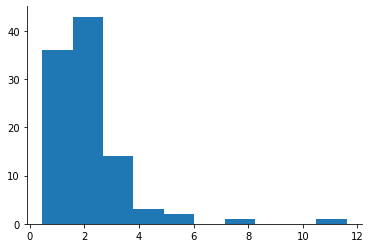

In [32]:
parms_true = np.array([2, 4])
f = loss_model("Inverse-Gaussian", ["μ", "λ"])
X = f.sample(parms_true, 100)
# X = st.invgauss(parms_true[0]).rvs(100)
plt.hist(X,bins=10)
sns.despine()
μ_prior, λ_prior = bs.prior_model('gamma','μ', 1, 1), bs.prior_model('gamma','λ', 1, 1)
prior_single_model = bs.independent_priors([μ_prior, λ_prior])

In [33]:
popSize = 2000
%time trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_single_model)

Sample generation 0 from the gamma-gamma prior distribution
Generation: 1 ;temperature: 0.009770393371582031 ;ESS: 999 ;steps:5 ;particle moved: 98.85000000000001%
Generation: 2 ;temperature: 0.03860053311336742 ;ESS: 999 ;steps:4 ;particle moved: 98.55000000000001%
Generation: 3 ;temperature: 0.10201451934484436 ;ESS: 999 ;steps:4 ;particle moved: 99.25%
Generation: 4 ;temperature: 0.24475313631323253 ;ESS: 999 ;steps:4 ;particle moved: 99.5%
Generation: 5 ;temperature: 0.6342532718307221 ;ESS: 999 ;steps:4 ;particle moved: 99.4%
Generation: 6 ;temperature: 1.0 ;ESS: 1639 ;steps:4 ;particle moved: 99.7%
Wall time: 2.74 s


-155.63810584306663 292.89648174205746 301.06441307613477


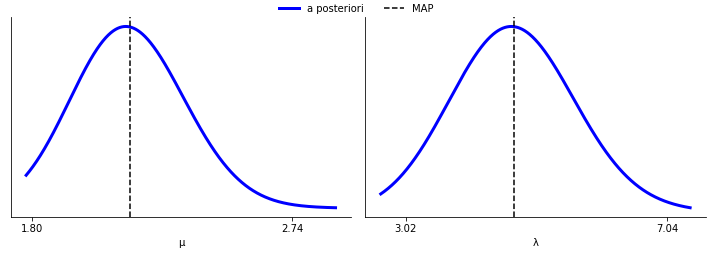

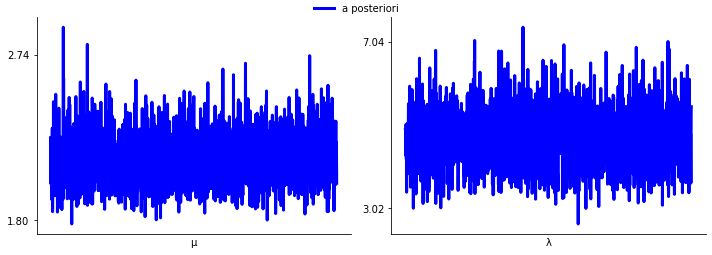

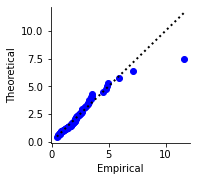

In [34]:
print(log_marg, DIC, WAIC)
f.set_ppf()
bs.posterior_plots(f, trace)
bs.trace_plots(f, trace)

bs.qq_plot(X, f, trace.mean().values)

## In the composite model

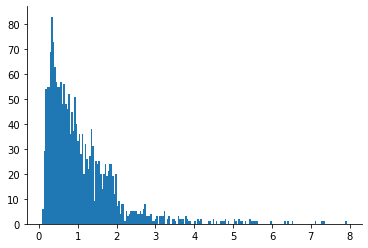

In [36]:
parms_true = np.array([3, 1, 2, 5, 2, 0.9])
f1, f2 =  loss_model("Inverse-Gaussian", ["μ1", "λ1"]), loss_model("Inverse-Gaussian", ["μ2", "λ2"])
f = bs.spliced_loss_model(f1 , f2, "disjoint") 
X= f.sample(parms_true, 2000)
plt.hist(X,bins=200)
sns.despine()


In [39]:
μ1_prior, λ1_prior = bs.prior_model('gamma','μ1', 1, 1), bs.prior_model('gamma','λ1', 1, 1)
μ2_prior, λ2_prior = bs.prior_model('gamma','μ2', 1, 1), bs.prior_model('gamma','λ2', 1, 1)
γ_prior, p_prior =  bs.prior_model('uniform','γ',min(X),max(X)), bs.prior_model('beta', 'p', 0.5, 0.5)
prior_spliced_model = bs.independent_priors([μ1_prior, λ1_prior, μ2_prior, λ2_prior, γ_prior, p_prior])
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 2000, 1/2, 0.99, 25, 1e-6, False, 4, True
%time trace, log_marg, DIC, WAIC = bs.smc(X, f, popSize, prior_spliced_model, ρ, c,n_step_max, err, paralell, 4, verbose)

Sample generation 0 from the gamma-gamma-gamma-gamma-uniform-beta prior distribution
Generation: 1 ;temperature: 0.00029850006103515625 ;ESS: 999 ;steps:3 ;particle moved: 99.95%
Generation: 2 ;temperature: 0.0015810005747880496 ;ESS: 1000 ;steps:3 ;particle moved: 99.95%
Generation: 3 ;temperature: 0.005056301407013729 ;ESS: 999 ;steps:3 ;particle moved: 99.9%
Generation: 4 ;temperature: 0.013475932733806699 ;ESS: 999 ;steps:3 ;particle moved: 99.9%
Generation: 5 ;temperature: 0.02970514112903589 ;ESS: 999 ;steps:3 ;particle moved: 99.8%
Generation: 6 ;temperature: 0.06246302937187852 ;ESS: 999 ;steps:3 ;particle moved: 99.45%
Generation: 7 ;temperature: 0.11126380314771735 ;ESS: 999 ;steps:3 ;particle moved: 99.7%
Generation: 8 ;temperature: 0.17898769526173727 ;ESS: 999 ;steps:3 ;particle moved: 99.4%
Generation: 9 ;temperature: 0.2842557648702942 ;ESS: 999 ;steps:3 ;particle moved: 99.6%
Generation: 10 ;temperature: 0.46348281843895744 ;ESS: 1000 ;steps:3 ;particle moved: 99.9%
Gen

-1906.2945744811616 3767.3039025827534 3782.7314827962623 [3.11059616 1.0938337  1.17951313 1.56627016 2.01466472 0.90033997]


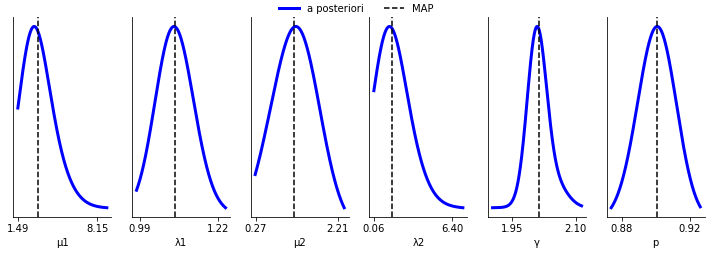

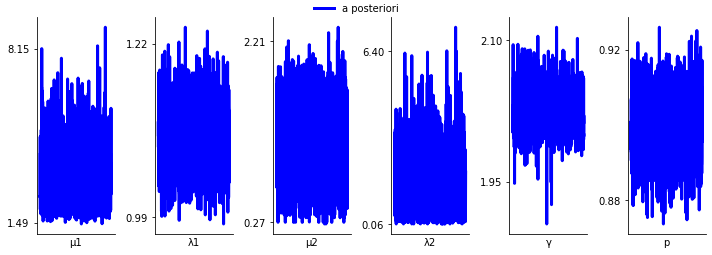

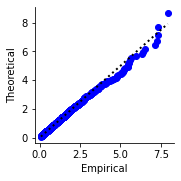

In [42]:
print(log_marg, DIC, WAIC, trace.mean().values)
f.set_ppf()
bs.posterior_plots(f, trace)
bs.trace_plots(f, trace)
bs.qq_plot(X, f, trace.mean().values)

# On the danish data set

In [20]:
# The data
danish = pd.read_csv("Data/danish.csv").x
X = danish.values
# Model for the bulk distribution
body_model_names = ["Inverse-Gaussian"]
body_model_param_names = [["μ1", "λ1"]]
# Prior distributions over the parameters of the bulk distribution
body_model_priors= [
                [ bs.prior_model('gamma',body_model_param_names[0][0], 1, 1), bs.prior_model('gamma',body_model_param_names[0][1], 1, 1)]]

# Model for the tail of the distribution
tail_model_names = ["Exp", "Gamma", "Weibull", "Inverse-Gaussian", "Lognormal", "Log-Logistic", "Lomax", "Burr", "Pareto-Tail", "GPD-Tail", "Inverse-Gamma", "Inverse-Weibull"]
# tail_model_names = ["Exp", "Gamma", "Weibull"]

tail_model_param_names = [['λ2'], ["r2", "m2"], ["k2", "β2"], ["μ2", "λ2"], ["μ2", "σ2"], ["β2", "σ2"], ["α2", "σ2"], ["α2", "β2", "σ2"], ["α2"], ["ξ2","σ2"], ["r2", "m2"], ["k2", "β2"]]

# Prior distributions over the parameters of the bulk distribution
tail_model_priors= [[bs.prior_model('gamma',tail_model_param_names[0][0], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[1][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[1][1], 1, 1)], 
                [bs.prior_model('gamma',tail_model_param_names[2][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[2][1], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[3][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[3][1], 1, 1)],
                [bs.prior_model('normal',tail_model_param_names[4][0], 0, 0.5), bs.prior_model('gamma',tail_model_param_names[4][1], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[5][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[5][1], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[6][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[6][1], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[7][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[7][1], 1, 1), bs.prior_model('gamma',tail_model_param_names[7][2], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[8][0], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[9][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[9][1], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[10][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[10][1], 1, 1)],
                [bs.prior_model('gamma',tail_model_param_names[11][0], 1, 1), bs.prior_model('gamma',tail_model_param_names[11][1], 1, 1)]
]
γ_prior, p_prior = bs.prior_model('fixed', "γ", 2.46, max(X)), bs.prior_model('uniform',"p", 0, 1)

#Splicing model type
splicing_types = ["continuous", "simple", "disjoint"]

# Setting the models
fs, f_names, prior_spliced_model = [], [], []
for i in range(len(body_model_names)):
    for j in range(len(tail_model_names)):
        for splicing_type in splicing_types:
            f1, f2 =  bs.loss_model(body_model_names[i], body_model_param_names[i]), bs.loss_model(tail_model_names[j], tail_model_param_names[j])
            fs.append(bs.spliced_loss_model(f1 , f2, splicing_type))
            f_names.append(body_model_names[i] +"-"+ tail_model_names[j]+"-"+splicing_type)
            if splicing_type == "disjoint": 
                prior_spliced_model.append(bs.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior, p_prior]))
            else:
                prior_spliced_model.append(bs.independent_priors(body_model_priors[i] + tail_model_priors[j] + [γ_prior]))

for f in fs:
    f.set_ppf()                
fs_dict = dict(zip(f_names, fs))

In [21]:
popSize, ρ, c, n_step_max, err, paralell, n_proc, verbose = 1000, 1/2, 0.99, 25, 1e-6, False, 4, False
def fit_spliced_models(i):
    print(f_names[i])
    trace, log_marg, DIC, WAIC = bs.smc_likelihood_annealing(X, fs[i], popSize, prior_spliced_model[i], ρ, c,n_step_max, err, paralell, 4, verbose)
    return([trace, log_marg, DIC, WAIC])
%time res = Parallel(n_jobs=4)(delayed(fit_spliced_models)(i) for i in range(len(f_names)))

Wall time: 3min 37s


In [22]:
fit_spliced_models_dic = dict(zip(f_names, res))
γ_map = np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))])
spliced_model_df = pd.DataFrame({'model':f_names,
                                 "d": np.array([f.d for f in fs]),
                                 "γ_map": np.array([fit_spliced_models_dic[f_names[k]][0]['γ'].mean() for k in range(len(fit_spliced_models_dic))]),
                                 'log_marg':  np.array([fit_spliced_models_dic[f_names[k]][1] for k in range(len(fit_spliced_models_dic))]), 
                                 "DIC": np.array([fit_spliced_models_dic[f_names[k]][2] for k in range(len(fit_spliced_models_dic))]), 
                                 "WAIC":np.array([fit_spliced_models_dic[f_names[k]][3] for k in range(len(fit_spliced_models_dic))])})
spliced_model_df["posterior_probability"] = np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"])) / np.sum(np.exp(spliced_model_df["log_marg"] - np.max(spliced_model_df["log_marg"]))) 

spliced_model_df["Wass_dist"] = np.array([bs.compute_Wasserstein(X, fs_dict[model_name], fit_spliced_models_dic[model_name][0].mean().values, 1) for model_name in spliced_model_df["model"].values])
spliced_model_df.sort_values(by='log_marg', ascending=False)

,model,d,γ_map,log_marg,DIC,WAIC,posterior_probability,Wass_dist
32,Inverse-Gaussian-Inverse-Gamma-disjoint,6,2.46,-3932.227155,7804.144683,7824.175644,3.594508e-01,411.968276
26,Inverse-Gaussian-Pareto-Tail-disjoint,5,2.46,-3932.493170,7806.328453,7823.833883,2.754930e-01,426.577577
17,Inverse-Gaussian-Log-Logistic-disjoint,6,2.46,-3933.358537,7804.782915,7823.825301,1.159541e-01,413.447235
20,Inverse-Gaussian-Lomax-disjoint,6,2.46,-3933.573622,7804.143815,7824.474596,9.351395e-02,420.858354
35,Inverse-Gaussian-Inverse-Weibull-disjoint,6,2.46,-3933.800044,7804.575159,7824.310885,7.456624e-02,403.775025
23,Inverse-Gaussian-Burr-disjoint,7,2.46,-3933.928455,9106.420784,7824.759926,6.558043e-02,2515.216134
29,Inverse-Gaussian-GPD-Tail-disjoint,6,2.46,-3935.451769,7802.583233,7825.733778,1.429577e-02,412.675560
33,Inverse-Gaussian-Inverse-Weibull-continuous,5,2.46,-3939.037038,7823.459490,7840.934694,3.964101e-04,480.115039
30,Inverse-Gaussian-Inverse-Gamma-continuous,5,2.46,-3939.835624,7825.286267,7842.435002,1.783706e-04,467.874043
14,Inverse-Gaussian-Lognormal-disjoint,6,2.46,-3940.128739,7814.712466,7834.349191,1.330532e-04,808.260009


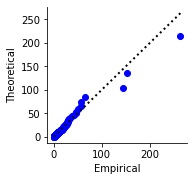

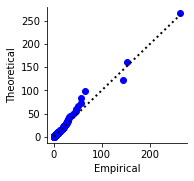

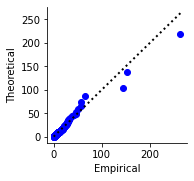

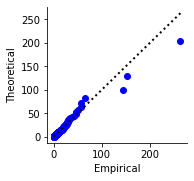

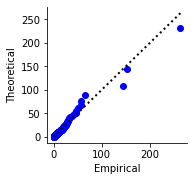

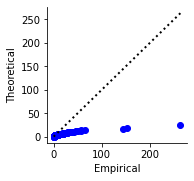

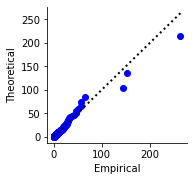

In [29]:
model_names = spliced_model_df.sort_values(by='log_marg', ascending=False)["model"][:7]
for model_name in model_names:
    f, trace = fs_dict[model_name], fit_spliced_models_dic[model_name][0]
    # print(trace.mean().values)
    # bs.posterior_plots(f, trace)
    # bs.trace_plots(f, trace)
    bs.qq_plot(X, f, trace.mean().values)